# Census Data Analysis

**Prediction task:** Determine whether a person makes over 50K a year.

**UCI Machine Learning Repository:** https://archive.ics.uci.edu/ml/datasets/Census+Income

## Import Dataset

In [1]:
''' 
The list of packages used for data analysis.
'''

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import sklearn.linear_model as sklm
import pylab
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
'''
Importing census data (adult.data) as a dataframe using Padas
'''
census_data = pd.read_csv("./Data/adult.data", 
                          sep = ",\s",
                          names = ["age", "workclass", "fnlwgt", "education","education_num", 
                                   "martial_status", "occupation","relationship","race","sex",
                                   "capital_gain","capital_loss", "hours_per_week","native_country", "salary"], 
                          engine = 'python') 

print "Dimensions of the dataset (rows, columns): " , census_data.shape

Dimensions of the dataset (rows, columns):  (32561, 15)


In [3]:
'''
A sneak-peak of the first few rows on the dataset
'''
head = int(raw_input("To display first N rows, enter N: "))
census_data.head(head)

To display first N rows, enter N: 6


,age,workclass,fnlwgt,education,education_num,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [4]:
'''
Distribution of dependent variable (salary)
'''
census_data.salary.value_counts()

<=50K    24720
>50K      7841
Name: salary, dtype: int64

In [5]:
'''
Checking the data types to make sure they are correctly coded
'''
census_data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
martial_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
salary            object
dtype: object

In [6]:
'''
Separating features (column names) based on the data types
''' 
obj_col_names = []
num_col_names = []

for i in census_data.columns.values:
    d_type = census_data[i].dtypes
    if d_type == "object":
        obj_col_names.append(i)
    else:
        num_col_names.append(i)
        
print "categorical features:", obj_col_names
print "numeric features:", num_col_names

categorical features: ['workclass', 'education', 'martial_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'salary']
numeric features: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


## Preprocessing of missing values

### Detect NA values

In [7]:
'''
Check for NA values in categorical features
'''
# print features containing NA/missing values
for i in obj_col_names:
    arr = census_data[i].values == '?'
    if (True in arr):
        print i, "has NA values"

workclass has NA values
occupation has NA values
native_country has NA values


In [8]:
'''
Check for NA values in numeric features
'''
df = census_data[num_col_names]
df.isnull().values.any()

False

NA values are present for **3 of the categorical features**. We can check the event-rate/distribution of the NA values w.r.t to the dependent variable and decide the optimal preprocessing step for dealing with the NA values.

### 1. workclass feature

In [9]:
'''
Checking the event-rate/distribution of '?' category of the workclass feature w.r.t. salary
'''
pd.crosstab(census_data.salary, census_data.workclass)['?']

salary
<=50K    1645
>50K      191
Name: ?, dtype: int64

Observations:
* Total NA values for the workclass feature = 1645+191 = **1836** 
* Percentage of NA values = 1836/32561 = **5.64%**
* Percentage of NA values for <=50K = 1645/24720 = **6.654%**
* Percentage of NA values for >50K = 191/7841 = **2.43%**

Now, lets check the distribution of each of the categories of the workclass variable

In [10]:
'''
Event rate of workclass w.r.t salary (%)
'''
pd.crosstab(census_data.salary, census_data.workclass).apply(lambda r: r/r.sum() * 100, axis=1)

workclass,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
salary,,,,,,,,,
<=50K,6.654531,2.382686,5.970874,0.028317,71.735437,1.998382,7.350324,3.822816,0.056634
>50K,2.435914,4.731539,7.868894,0.000000,63.295498,7.932662,9.233516,4.501977,0.000000


Since the **Private** category of the workclass feature has the highest distribution w.r.t the dependent variable categories, we can impute the **'?'** to this category.

### 2. occupation feature

In [11]:
'''
Checking the event-rate/distribution of '?' category of the occupation feature w.r.t. salary
'''
pd.crosstab(census_data.salary, census_data.occupation)['?']

salary
<=50K    1652
>50K      191
Name: ?, dtype: int64

Observations:
* Total NA values for the workclass feature = 1645+191 = **1836** 
* Percentage of NA values = 1836/32561 = **5.64%**
* Percentage of NA values for <=50K = 1645/24720 = **6.654%**
* Percentage of NA values for >50K = 191/7841 = **2.43%**

Now, lets check the distribution of each of the categories of the occupation variable

In [12]:
'''
Event rate of occupation w.r.t salary (%)
'''
pd.crosstab(census_data.salary, census_data.occupation).apply(lambda r: r/r.sum() * 100, axis=1)

occupation,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
salary,,,,,,,,,,,,,,,
<=50K,6.682848,13.199838,0.032362,12.823625,8.487055,3.555825,5.194175,7.087379,12.775081,0.598706,9.227346,1.771845,10.788835,2.609223,5.165858
>50K,2.435914,6.466012,0.012753,11.847979,25.098839,1.466650,1.096799,3.188369,1.747226,0.012753,23.708711,2.690983,12.536666,3.609234,4.081112


Since none the categories of the occupation feature have a skewed distribution as such, we can **drop** the '?' for this feature.

### 3. native_country

In [13]:
'''
Checking the event-rate/distribution of '?' category of the native_country feature w.r.t. salary
'''
pd.crosstab(census_data.salary, census_data.native_country)['?']

salary
<=50K    437
>50K     146
Name: ?, dtype: int64

Observations:
* Total NA values for the workclass feature = 437+146 = **583** 
* Percentage of NA values = 583/32561 = **1.8%**
* Percentage of NA values for <=50K = 437/24720 = **1.77%**
* Percentage of NA values for >50K = 146/7841 = **1.86%**

Now, lets check the distribution of each of the categories of the occupation variable

In [14]:
'''
Event rate of native_country w.r.t salary (%)
'''
pd.crosstab(census_data.salary, census_data.native_country).apply(lambda r: r/r.sum() * 100, axis=1)

native_country,?,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
salary,,,,,,,,,,,,,,,,,,,,,
<=50K,1.767799,0.048544,0.331715,0.222492,0.230583,0.283172,0.275081,0.097087,0.392395,0.242718,...,0.133495,0.412621,0.036408,0.258900,0.125405,0.06068,0.068770,88.992718,0.250809,0.040453
>50K,1.862007,0.089274,0.497386,0.255070,0.025507,0.318837,0.025507,0.051014,0.114781,0.382604,...,0.051014,0.153042,0.038260,0.204056,0.255070,0.03826,0.025507,91.455172,0.063767,0.076521


Since the **United-States** category of the native_country feature has the highest distribution w.r.t the dependent variable categories, we can impute the '?' to this category. 

### Imputation

Observations:
* Total NA values for all features = 1836+1836+583 = **4255**
* Percentage of NA values for the entire dataset = 4255/32561 = **13.07%**
* Percentage of NA values for <=50K = (1645+1652+437)/24720 = **15.1%**
* Percentage of NA values for >50K = (191+191+146)/7841 = **6.73%**

In [15]:
'''
Imputing workclass '?' features to private
'''
census_data['workclass'] = census_data['workclass'].replace('?', 'Private')
census_data['native_country'] = census_data['native_country'].replace('?','United-States')

# drop the remaining rows containing '?'
census_data = census_data.replace("?", np.nan)
census_data = census_data.dropna(axis = 0)

In [16]:
'''
Check for NA values once again to make sure none
'''
# print features containing NA values
for i in obj_col_names:
    arr = census_data[i].values == '?'
    if (True in arr):
        print i, "has NA values"

In [17]:
'''
Fix row indexes
'''
census_data = census_data.reset_index(drop=True)

## Exploratory Data Analysis

In [18]:
'''
Encode salary variable as binary, <=50k => 0 and >50k => 1
'''
census_data.salary = census_data.salary.astype('category').cat.codes

### 1. Numeric Features

In [19]:
'''
Displaying Summary statisitcs of all the numeric variables in the dataset. 
'''
census_data.describe(percentiles=True)

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,salary
count,30718.000000,3.071800e+04,30718.000000,30718.000000,30718.000000,30718.000000,30718.000000
mean,38.443584,1.898455e+05,10.130314,1106.037079,88.910216,40.949313,0.249040
std,13.118227,1.054583e+05,2.562469,7497.863364,405.657203,11.985382,0.432464
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000,0.000000
50%,37.000000,1.785170e+05,10.000000,0.000000,0.000000,40.000000,0.000000
100%,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


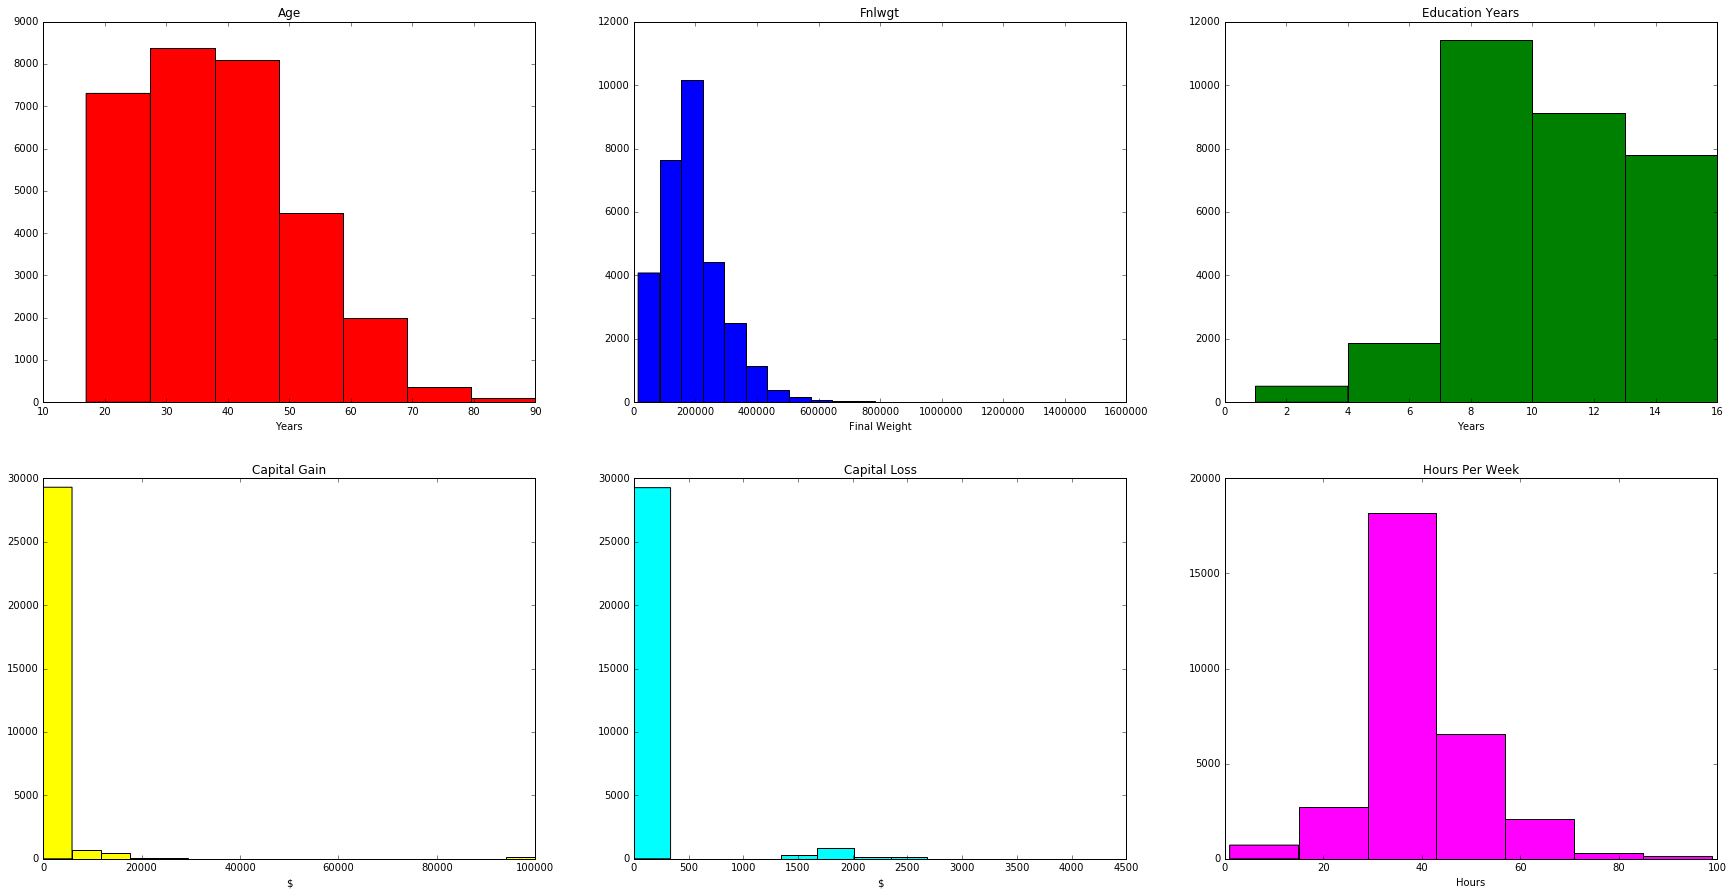

In [20]:
'''
Histogram is a graphical representation of the numerical data. 

Decide the number of classes/bins using the “2 to the k rule”, where k is the number of classes/bins. 
Select the smallest number k such that 2^k is greater than the number of observations. 
Example – For 180 observations, 8 would be the ideal numbers of bins as 2^8 = 256 
(the smallest 2^k number greater than the number of observations; 2^7 = 128).
''' 

%pylab inline
plt.figure(figsize=(30,15))

plt.subplot(2, 3, 1)
plt.hist(census_data['age'], bins=7, color='red')
plt.title('Age')
plt.xlabel('Years')

plt.subplot(2, 3, 2)
plt.hist(census_data['fnlwgt'], bins=21, color='blue')
plt.xlabel(['2k','3'])
plt.title('Fnlwgt')
plt.xlabel('Final Weight')

plt.subplot(2, 3, 3)
plt.hist(census_data['education_num'], bins=5, color='green')
plt.title('Education Years')
plt.xlabel('Years')

plt.subplot(2, 3, 4)
plt.hist(census_data['capital_gain'], bins=17, color='yellow')
plt.title('Capital Gain')
plt.xlabel('$')

plt.subplot(2, 3, 5)
plt.hist(census_data['capital_loss'], bins=13, color='cyan')
plt.title('Capital Loss')
plt.xlabel('$')

plt.subplot(2, 3, 6)
plt.hist(census_data['hours_per_week'], bins=7, color='magenta')
plt.title('Hours Per Week')
plt.xlabel('Hours')

pylab.show()

Observations:
* **capital_gain** and **capital_loss** have most of the values falling only in 1 bin, but have a high variance. They are extremely right-skewed. 
* **fnlwgt** feature is right-skewed. 

When data is right skewed, the extreme values in the long tail can have a disproportionately large influence on whatever test you perform or models you build. Reducing skew may improve your results. Taking the square root of each data point or taking the natural logarithm of each data point are two simple transformations that can reduce skew.

Populating the interactive namespace from numpy and matplotlib


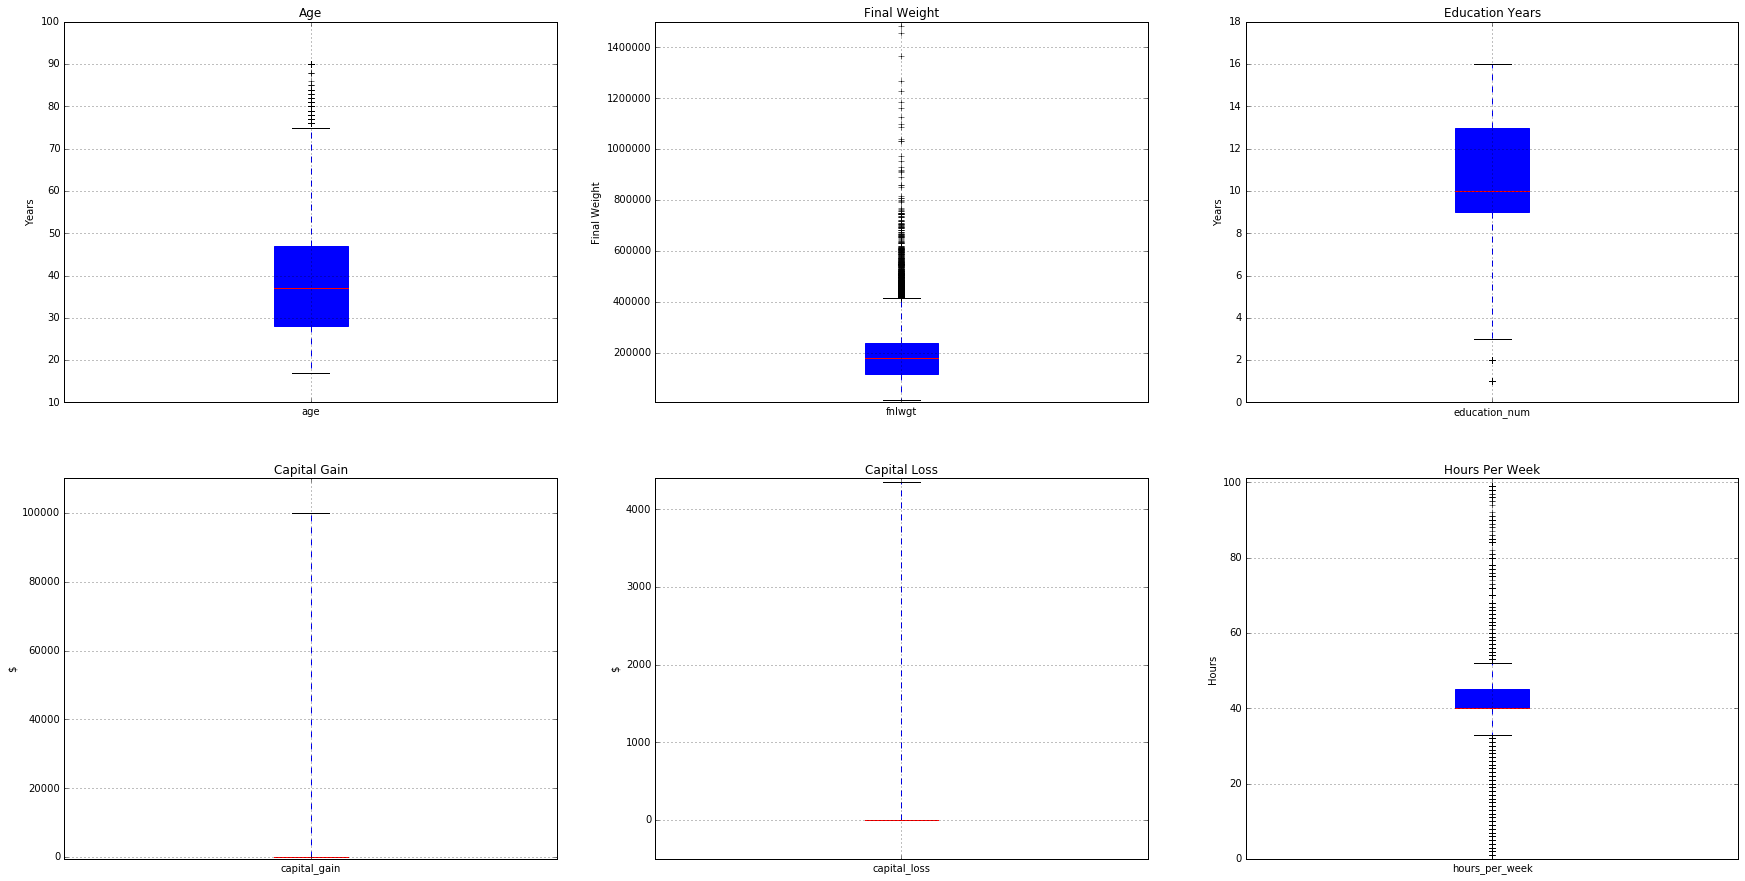

In [21]:
'''
Box plots are useful for highlighting outliers and highlighting the mass of the data.
The Box plots for the above numeric data to depict the 5 number summary is shown below. 
'''

%pylab inline 
plt.figure(figsize=(30,15))

plt.subplot(2, 3, 1)
bp = census_data.boxplot(column = ['age'], patch_artist = True, return_type='dict')
plt.ylim(10,100)
plt.title('Age')
plt.ylabel('Years')

plt.subplot(2, 3, 2)
census_data.boxplot(column = ['fnlwgt'], patch_artist = True, return_type='dict')
plt.ylim(5000,1500000)
plt.title('Final Weight')
plt.ylabel('Final Weight')

plt.subplot(2, 3, 3)
census_data.boxplot(column = ['education_num'],patch_artist = True, return_type='dict')
plt.ylim(0,18)
plt.title('Education Years')
plt.ylabel('Years')

plt.subplot(2, 3, 4)
census_data.boxplot(column = ['capital_gain'],patch_artist = True, return_type='dict')
plt.ylim(-500,110000)
plt.title('Capital Gain')
plt.ylabel('$')

plt.subplot(2, 3, 5)
census_data.boxplot(column = ['capital_loss'],patch_artist = True, return_type='dict')
plt.ylim(-500,4400)
plt.title('Capital Loss')
plt.ylabel('$')

plt.subplot(2, 3, 6)
census_data.boxplot(column = ['hours_per_week'],patch_artist = True, return_type='dict')
plt.ylim(0,101)
plt.title('Hours Per Week')
plt.ylabel('Hours')

pylab.show()

Populating the interactive namespace from numpy and matplotlib


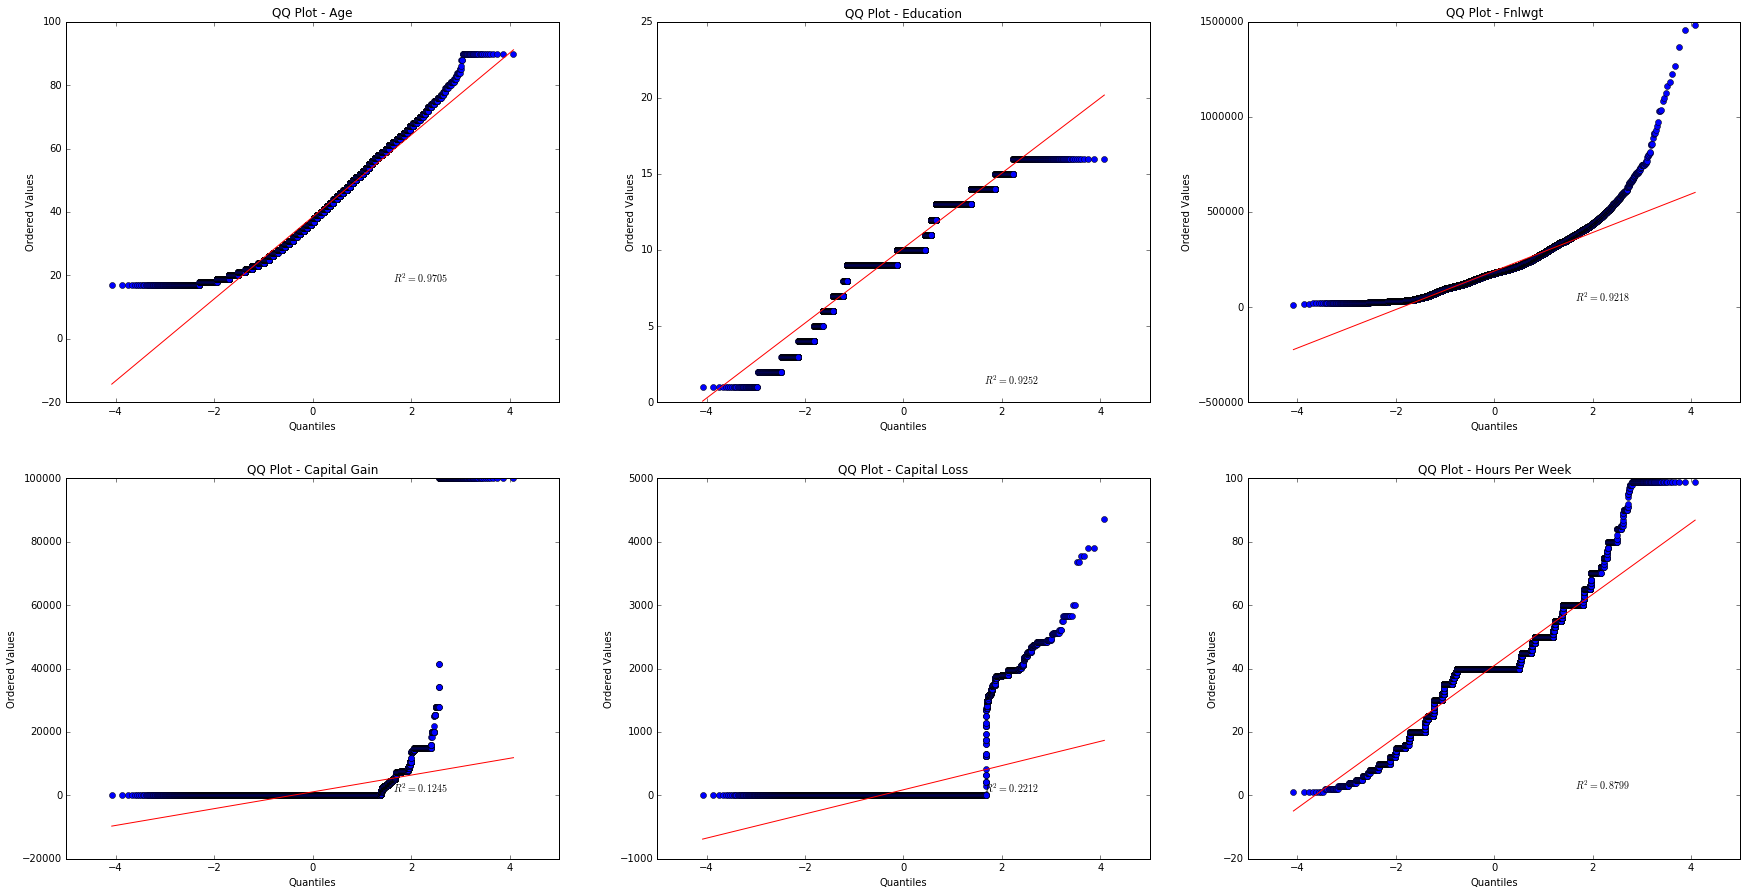

In [22]:
'''
Plotting the distribution for each numeric variable using qq-plots against Gaussian.
The more linear the plot (straight line, 45 degree angle), the distribution is closer to Normal Distribution.
If the qq-plot follows a S-shape, the distribution is more skewed compared to the Normal Distribution.
'''

%pylab inline
plt.figure(figsize=(30,15))

plt.subplot(2, 3, 1)
stats.probplot(census_data['age'], dist = "norm", plot=pylab)
plt.title('QQ Plot - Age')

plt.subplot(2, 3, 2)
stats.probplot(census_data['education_num'], dist = "norm", plot=pylab)
plt.title('QQ Plot - Education')

plt.subplot(2, 3, 3)
stats.probplot(census_data['fnlwgt'], dist = "norm", plot=pylab)
plt.title('QQ Plot - Fnlwgt')

plt.subplot(2, 3, 4)
stats.probplot(census_data['capital_gain'], dist = "norm", plot=pylab)
plt.title('QQ Plot - Capital Gain')

plt.subplot(2, 3, 5)
stats.probplot(census_data['capital_loss'], dist = "norm", plot=pylab)
plt.title('QQ Plot - Capital Loss')

plt.subplot(2, 3, 6)
stats.probplot(census_data['hours_per_week'], dist = "norm", plot=pylab)
plt.title('QQ Plot - Hours Per Week')

pylab.show()

Populating the interactive namespace from numpy and matplotlib


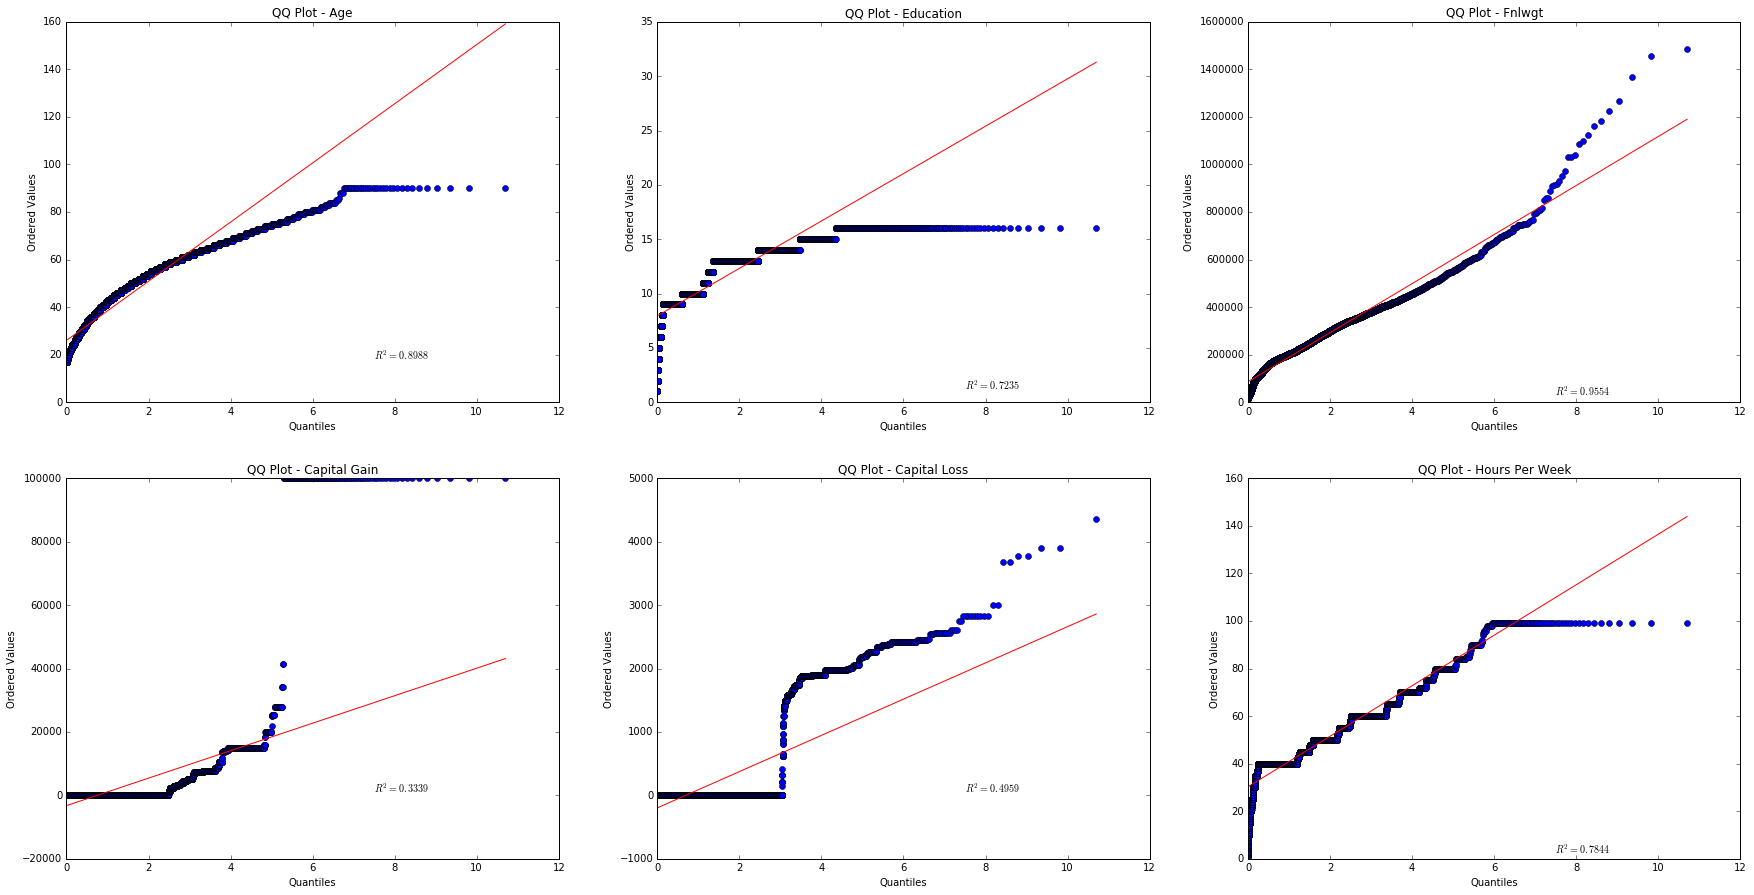

In [23]:
'''
Plotting the distribution for each numeric variable using qq-plots against Power Law Distribution.
The more linear the plot (straight line, 45 degree angle), the distribution is closer to Exponential. 
If the qq-plot follows a S-shape, the distribution is more skewed compared to the Exponential Distribution.
'''

%pylab inline
plt.figure(figsize=(30,15))

plt.subplot(2, 3, 1)
stats.probplot(census_data['age'], dist = "expon", plot=pylab)
plt.title('QQ Plot - Age')

plt.subplot(2, 3, 2)
stats.probplot(census_data['education_num'], dist = "expon", plot=pylab)
plt.title('QQ Plot - Education')

plt.subplot(2, 3, 3)
stats.probplot(census_data['fnlwgt'], dist = "expon", plot=pylab)
plt.title('QQ Plot - Fnlwgt')

plt.subplot(2, 3, 4)
stats.probplot(census_data['capital_gain'], dist = "expon", plot=pylab)
plt.title('QQ Plot - Capital Gain')

plt.subplot(2, 3, 5)
stats.probplot(census_data['capital_loss'], dist = "expon", plot=pylab)
plt.title('QQ Plot - Capital Loss')

plt.subplot(2, 3, 6)
stats.probplot(census_data['hours_per_week'], dist = "expon", plot=pylab)
plt.title('QQ Plot - Hours Per Week')

pylab.show()

Observations:
* The feature **fnlwgt** has a distribution closer to exponential. This information is useful for feature engineering.
* The features **age**, **education** and **hours_per_week** have an approximate normal distribution. Thus, these features can be used directly for modeling.

In [24]:
'''
Pearson Correlation Matrix for numeric variables.
'''
census_data.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,salary
age,1.000000,-0.076540,0.043567,0.080392,0.060409,0.101879,0.242431
fnlwgt,-0.076540,1.000000,-0.043509,-0.000189,-0.010011,-0.022810,-0.009446
education_num,0.043567,-0.043509,1.000000,0.124247,0.079321,0.151241,0.334640
capital_gain,0.080392,-0.000189,0.124247,1.000000,-0.032332,0.079548,0.221871
capital_loss,0.060409,-0.010011,0.079321,-0.032332,1.000000,0.053961,0.151461
hours_per_week,0.101879,-0.022810,0.151241,0.079548,0.053961,1.000000,0.228547
salary,0.242431,-0.009446,0.334640,0.221871,0.151461,0.228547,1.000000


Observation:
* **fnlwgt** is highly **uncorrelated** with the salary and thus might not be an important feature to model salary. However, a transformed fnlwgt feature might have a higher correlation.

### 2. Categorical Features

We can look for the categories which have an even distribution (50/50) w.r.t to the dependent variable and merge these categories.

In [25]:
pd.crosstab(census_data['workclass'], census_data['salary']).apply(lambda r: r/r.sum() * 100, axis=1)

salary,0,1
workclass,,
Federal-gov,61.354167,38.645833
Local-gov,70.520784,29.479216
Private,78.132711,21.867289
Self-emp-inc,44.265233,55.734767
Self-emp-not-inc,71.507281,28.492719
State-gov,72.804314,27.195686
Without-pay,100.000000,0.000000


In [26]:
pd.crosstab(census_data['education'], census_data['salary']).apply(lambda r: r/r.sum() * 100, axis=1)

salary,0,1
education,,
10th,92.779783,7.220217
11th,94.318182,5.681818
12th,92.111959,7.888041
1st-4th,96.153846,3.846154
5th-6th,95.379538,4.620462
7th-8th,93.368237,6.631763
9th,94.384449,5.615551
Assoc-acdm,74.607843,25.392157
Assoc-voc,73.656321,26.343679


In [27]:
pd.crosstab(census_data['martial_status'], census_data['salary']).apply(lambda r: r/r.sum() * 100, axis=1)

salary,0,1
martial_status,,
Divorced,89.267262,10.732738
Married-AF-spouse,52.380952,47.619048
Married-civ-spouse,54.522631,45.477369
Married-spouse-absent,91.516710,8.483290
Never-married,95.137207,4.862793
Separated,93.117831,6.882169
Widowed,90.357143,9.642857


Observations:
* No categories are to be merged for the workclass and education features.
* We can **merge** the **Married-AF-spouse and Married-civ-spouse** categories for the martial_status feature

In [28]:
pd.crosstab(census_data['occupation'], census_data['salary']).apply(lambda r: r/r.sum() * 100, axis=1)

salary,0,1
occupation,,
Adm-clerical,86.551724,13.448276
Armed-Forces,88.888889,11.111111
Craft-repair,77.335936,22.664064
Exec-managerial,51.598623,48.401377
Farming-fishing,88.430584,11.569416
Handlers-cleaners,93.722628,6.277372
Machine-op-inspct,87.512488,12.487512
Other-service,95.842185,4.157815
Priv-house-serv,99.328859,0.671141


In [29]:
pd.crosstab(census_data['relationship'], census_data['salary']).apply(lambda r: r/r.sum() * 100, axis=1)

salary,0,1
relationship,,
Husband,54.431675,45.568325
Not-in-family,89.345200,10.654800
Other-relative,96.078431,3.921569
Own-child,98.541436,1.458564
Unmarried,93.396515,6.603485
Wife,50.871080,49.128920


Observations:
* No categories are to be merged for the salary feature
* We can **merge** the **Husband and Wife** categories for the relationship feature

In [30]:
pd.crosstab(census_data['race'], census_data['salary']).apply(lambda r: r/r.sum() * 100, axis=1)

salary,0,1
race,,
Amer-Indian-Eskimo,88.111888,11.888112
Asian-Pac-Islander,72.176591,27.823409
Black,87.005844,12.994156
Other,90.725806,9.274194
White,73.597962,26.402038


In [31]:
pd.crosstab(census_data['sex'], census_data['salary']).apply(lambda r: r/r.sum() * 100, axis=1)

salary,0,1
sex,,
Female,88.650554,11.349446
Male,68.621320,31.378680


In [32]:
pd.crosstab(census_data['native_country'], census_data['salary']).apply(lambda r: r/r.sum() * 100, axis=1)

salary,0,1
native_country,,
Cambodia,61.111111,38.888889
Canada,66.355140,33.644860
China,70.588235,29.411765
Columbia,96.428571,3.571429
Cuba,72.826087,27.173913
Dominican-Republic,97.014925,2.985075
Ecuador,85.185185,14.814815
El-Salvador,91.000000,9.000000
England,65.116279,34.883721


Observations:
* No categories are to be merged for the native_country, sex and race features
* Other categories of the features can be merged later of the feature is found important

Populating the interactive namespace from numpy and matplotlib

Enter the name of the category to display.
Choose from workclass, education, martial_status, occupation, relationship, race, sex, native_country and salary:
workclass


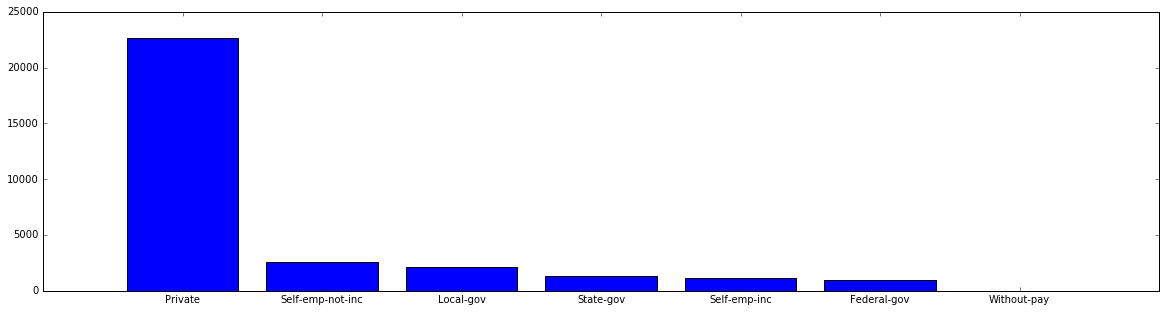

In [33]:
'''
The bar plot shows the frequency of the categorical variable. 
Enter the name of the categorical variable to look at the bar plot. 
This plot is dynamic in nature. On entering a different category, and pressing cntrl + Enter, the plot will change.
'''

%pylab inline
plt.figure(figsize=(30,15))

print "\nEnter the name of the category to display."
print "Choose from workclass, education, martial_status, occupation, relationship, race, sex, native_country and salary:"
category = raw_input()

dictionary = {
    "workclass" : 1,
    "education" : 3,
    "martial_status": 5,
    "occupation": 6,
    "relationship": 7,
    "race": 8,
    "sex": 9,
    "native_country": 13,
    "salary": 14
}

index = dictionary[category]

series = census_data.ix[:,index]
counts = series.value_counts()

cat = []
y_height = []

for i in counts.keys():
    cat.append(i)
    y_height.append(counts[i])

y_pos = np.arange(len(cat))

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.bar(y_pos,y_height, align = 'center')
plt.xticks(y_pos, cat)
plt.show()

Populating the interactive namespace from numpy and matplotlib

Enter the name of the category to display.
Choose from workclass, education, martial_status, occupation, relationship, race, sex, native country and salary:
education


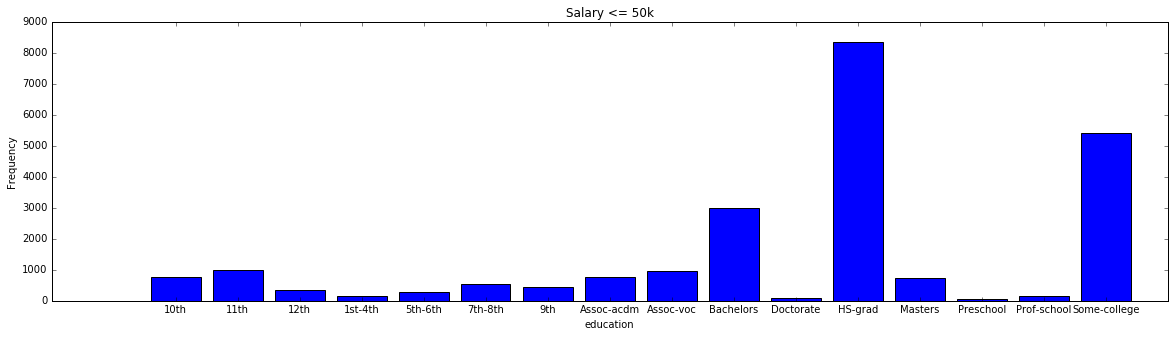

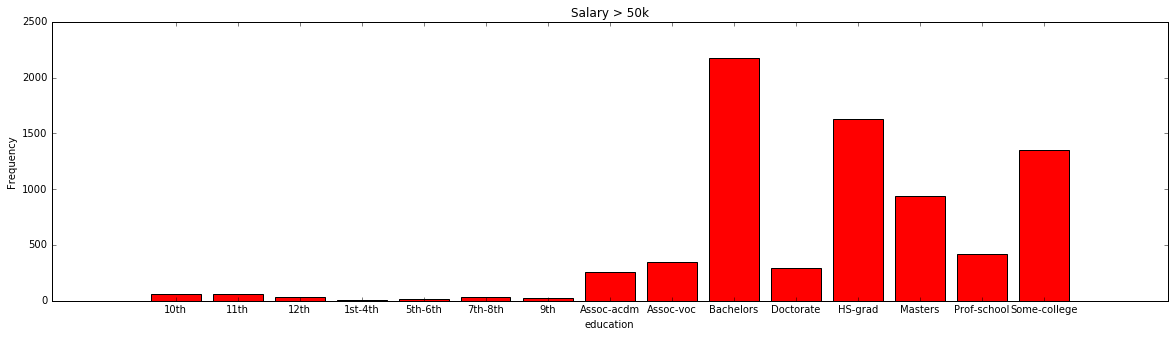

In [34]:
'''
The bar charts below shows the count of each indipendent variable with respect to the dependent variable.
For each variable, the bar plot shows the count for <= 50K (blue) and > 50k (red).
The plot is dynamic and thus the variable of interest is to be enetered by the user.
'''

%pylab inline
plt.figure(figsize=(30,15))

print "\nEnter the name of the category to display."
print "Choose from workclass, education, martial_status, occupation, relationship, race, sex, native country and salary:"
category = raw_input()

group = census_data.groupby([category,'salary']).size()
less_than_50k = group.ix[:,0]
greater_than_50k = group.ix[:,1]

labels_0 = []
values_0 = []
count_0 = 0

labels_1 = []
values_1 = []
count_1 = 0

for elem in less_than_50k.keys():
    labels_0.append(elem)
    values_0.append(less_than_50k[count_0])
    count_0 += 1
    
for elem in greater_than_50k.keys():
    labels_1.append(elem)
    values_1.append(greater_than_50k[count_1])
    count_1 += 1
    

y_pos1 = np.arange(len(labels_0))
y_pos2 = np.arange(len(labels_1))

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.bar(y_pos1,values_0, align = 'center')
plt.xticks(y_pos1, labels_0)
plt.title('Salary <= 50k')
plt.xlabel(category)
plt.ylabel('Frequency')

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.bar(y_pos2,values_1, align = 'center', color = 'red')
plt.xticks(y_pos2, labels_1)
plt.title('Salary > 50k')
plt.xlabel(category)
plt.ylabel('Frequency')
plt.show()

## Feature Engineering

### 1. fnlwgt

Populating the interactive namespace from numpy and matplotlib


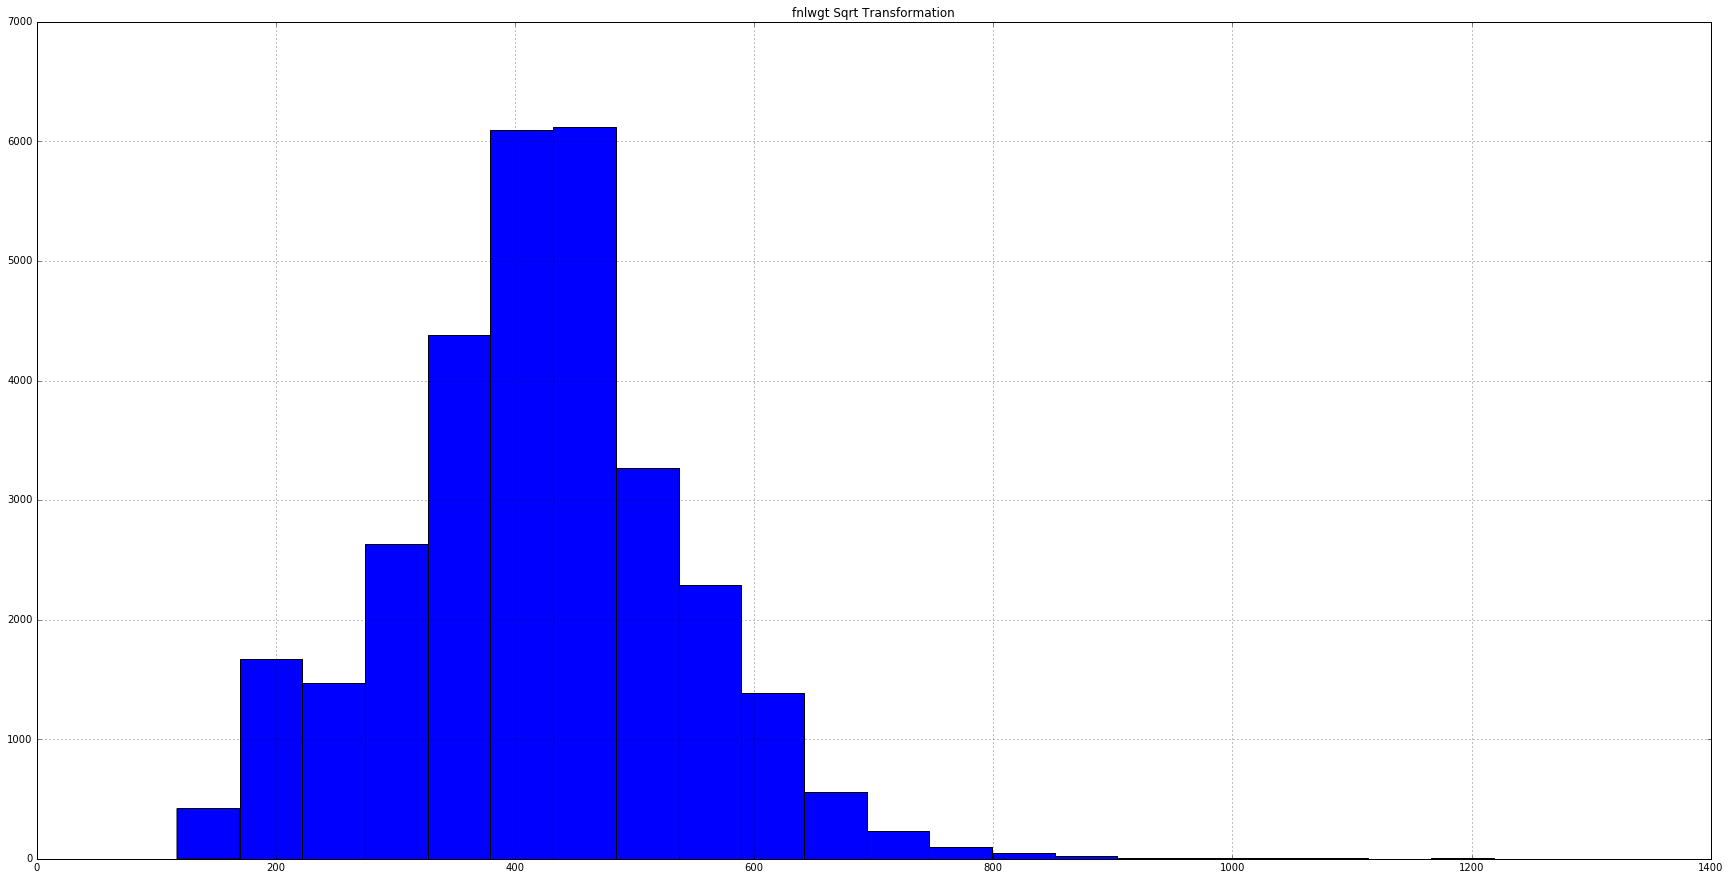

In [35]:
'''
Check the distribtion of fnlwgt after applying a square-root transformation
'''
%pylab inline
plt.figure(figsize=(30,15))

plt.title('fnlwgt Sqrt Transformation')
sqrt_transformed = census_data.fnlwgt.apply(np.sqrt) # Get the square root of data points*
sqrt_transformed.hist(bins=21)

Populating the interactive namespace from numpy and matplotlib


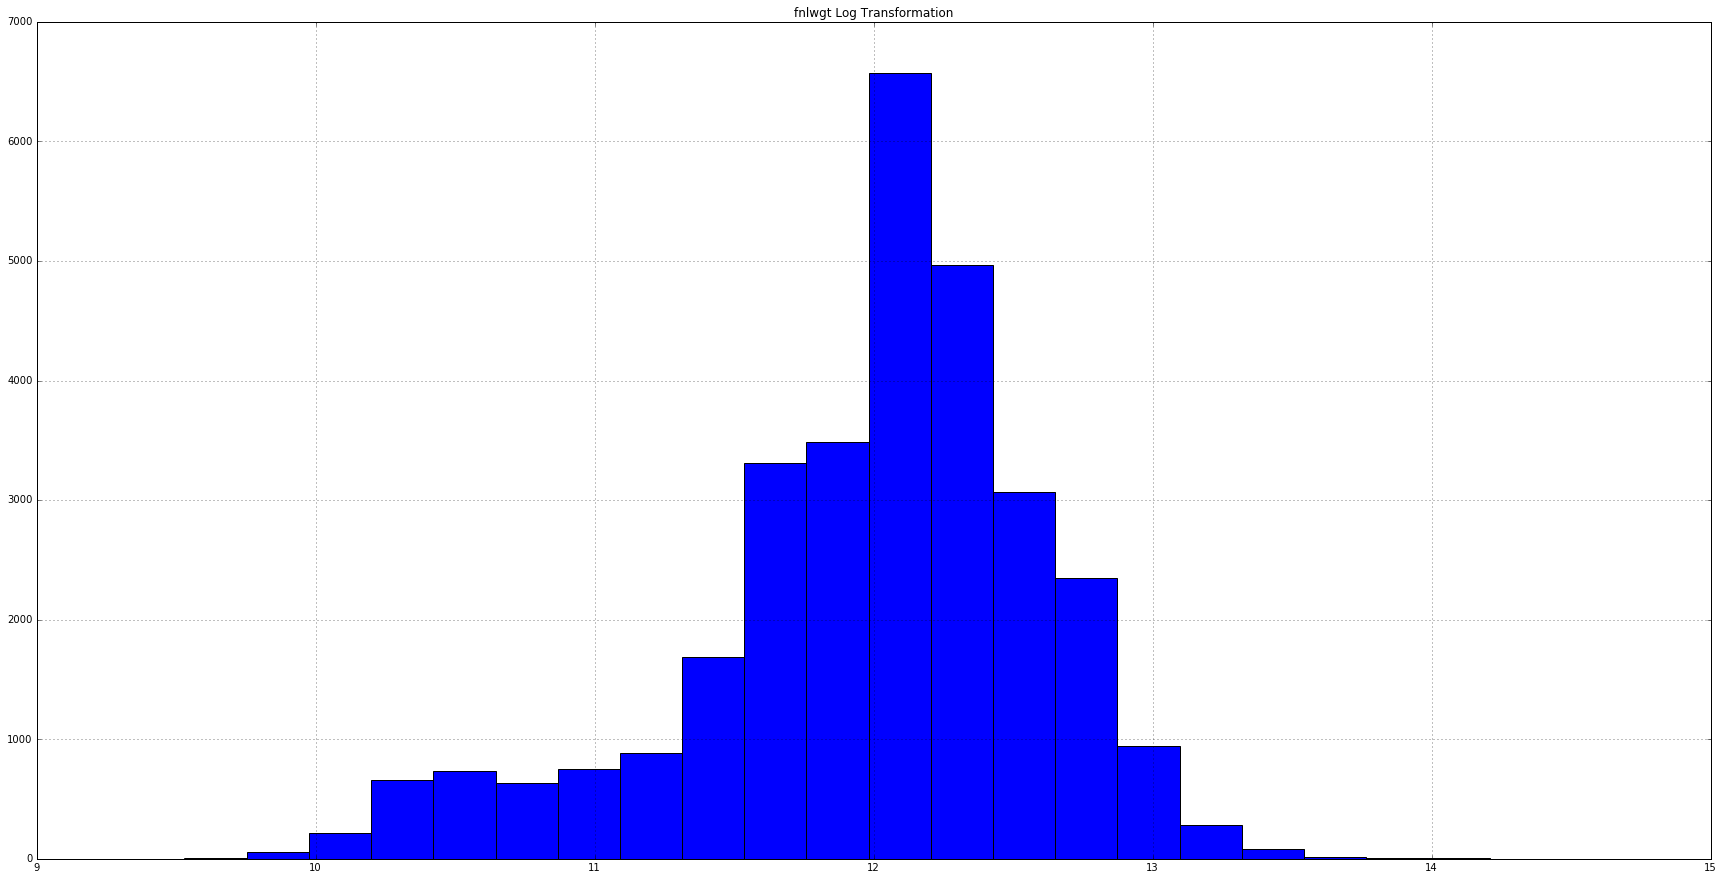

In [36]:
'''
Check the distribtion of fnlwgt after applying a log transformation
'''
%pylab inline
plt.figure(figsize=(30,15))
plt.title('fnlwgt Log Transformation')

log_transformed = (census_data.fnlwgt+1).apply(np.log)   # Get the log of the data
log_transformed.hist(bins=21)

Observations:
* The feature **fnlwgt** has an approximate normal distribution after square-root transformation. This feature will hence be transformed (square-root transformation) before modeling.

In [37]:
'''
Add sq-root transformed fnlwgt as a new feature
'''
census_data['fnlwgt_transformed'] = sqrt_transformed

### 2. capital_gain & capital_loss

Populating the interactive namespace from numpy and matplotlib


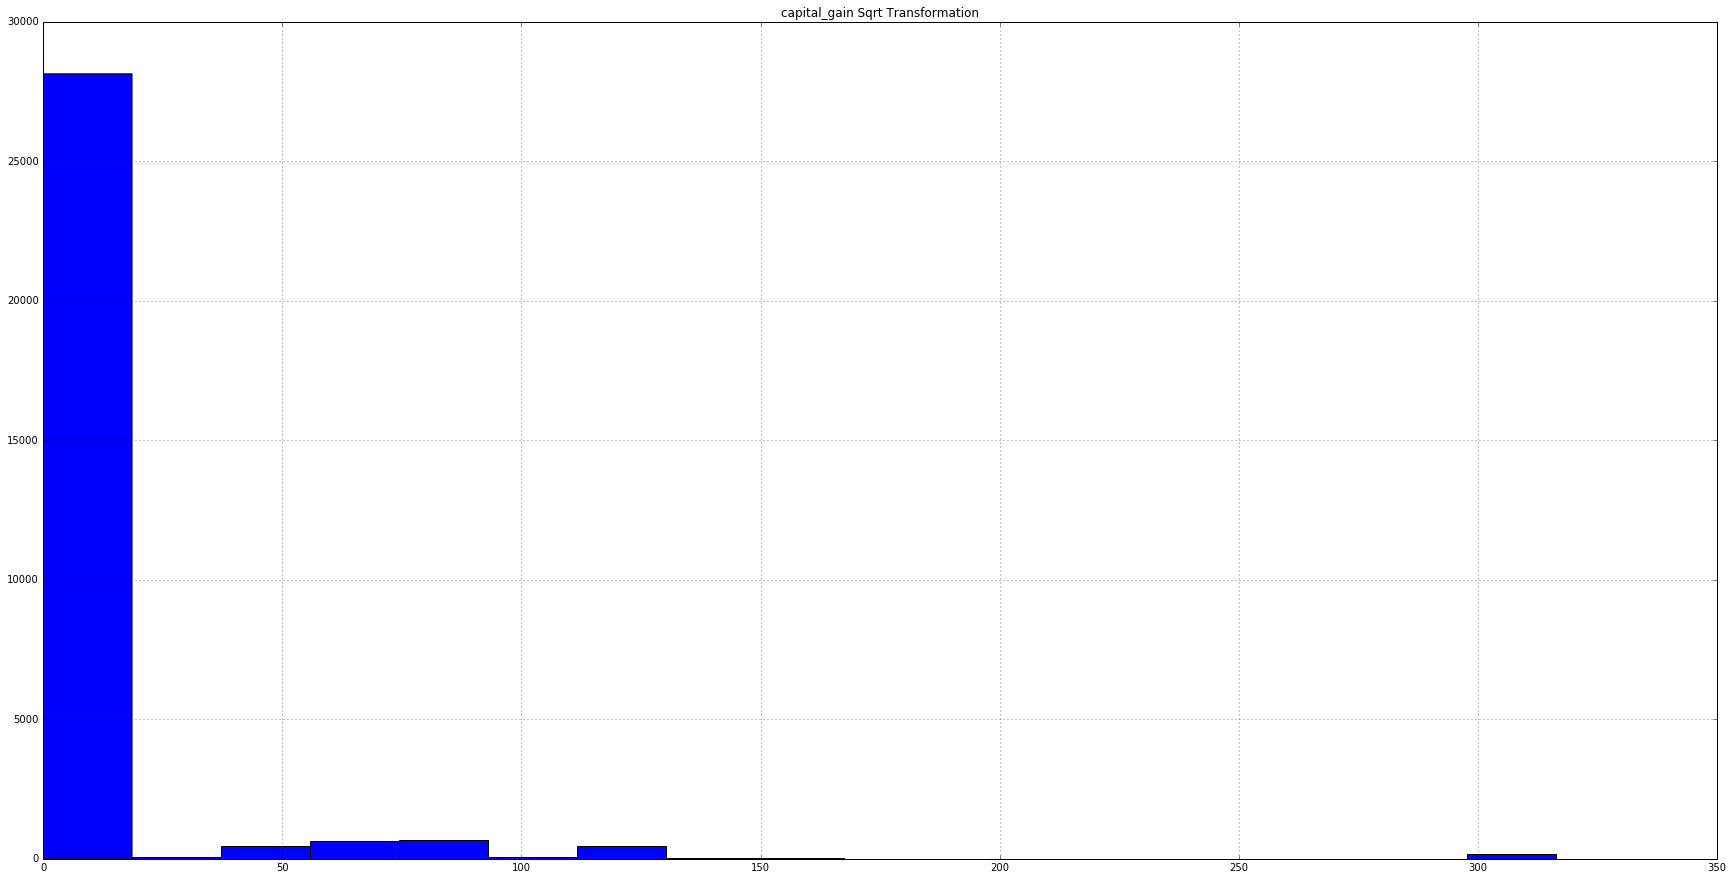

In [38]:
'''
Check the distribtion of capital_gain after applying a square-root transformation
'''
%pylab inline
plt.figure(figsize=(30,15))

plt.title('capital_gain Sqrt Transformation')
sqrt_transformed = census_data.capital_gain.apply(np.sqrt) # Get the square root of data points*
sqrt_transformed.hist(bins=17)

Populating the interactive namespace from numpy and matplotlib


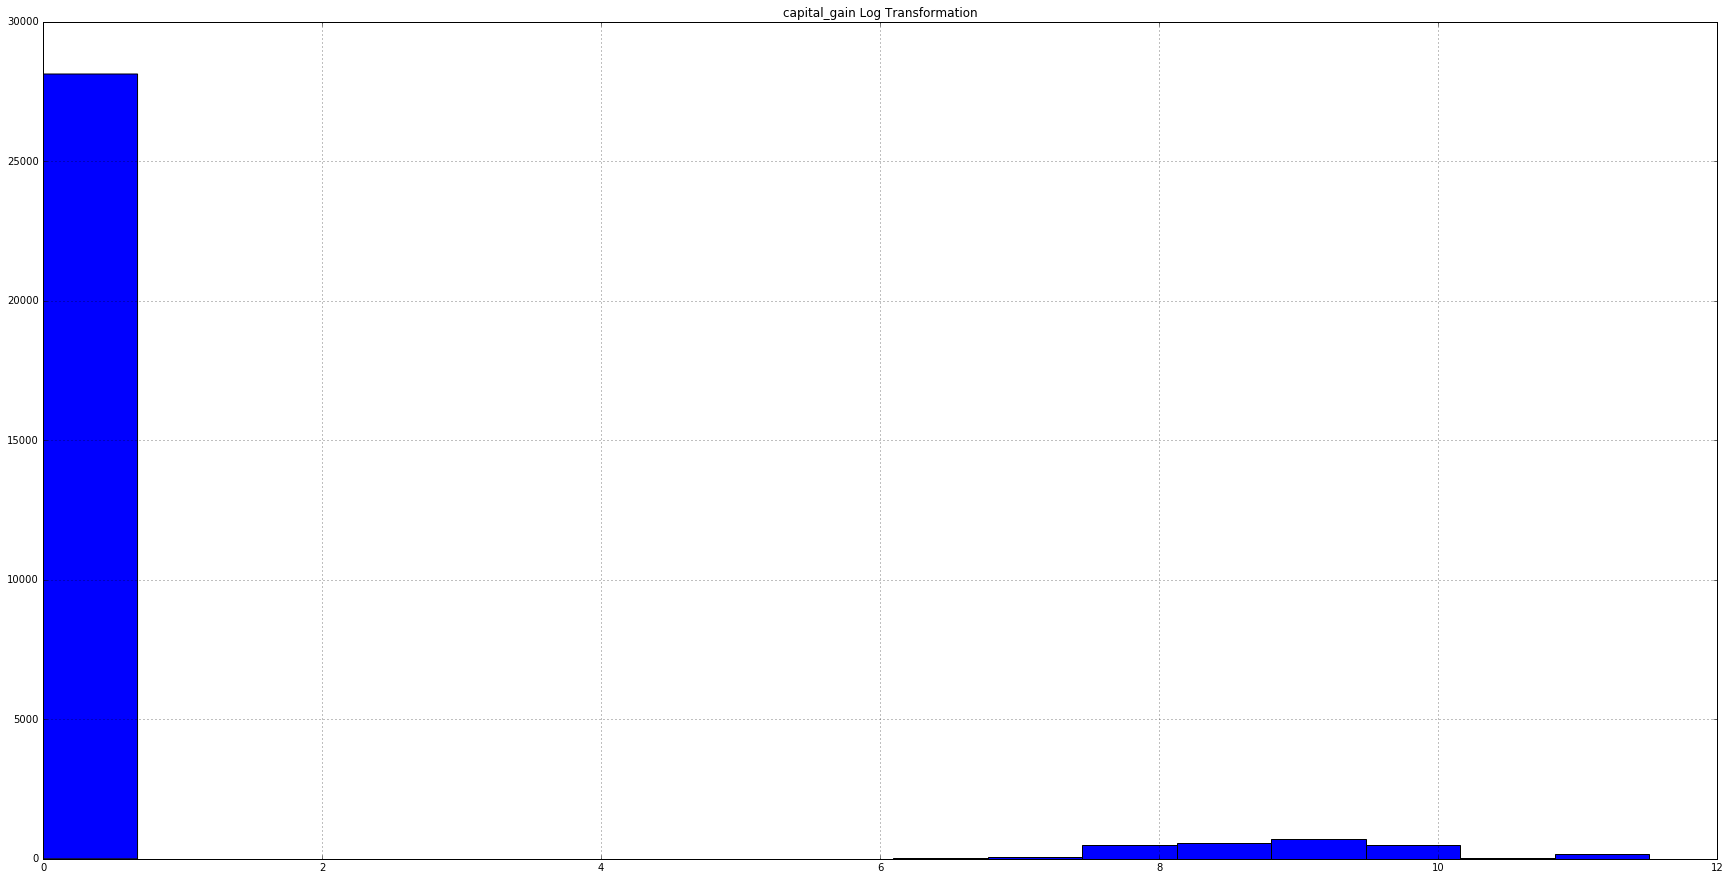

In [39]:
'''
Check the distribtion of capital_gain after applying a square-root transformation
'''
%pylab inline
plt.figure(figsize=(30,15))
plt.title('capital_gain Log Transformation')

log_transformed = (census_data.capital_gain+1).apply(np.log)   # Get the log of the data
log_transformed.hist(bins=17)

Since the transformations above have not helped to normalize the data, we can block the data into **3 separate bins: None (representing 0), Low and High**. We can do this for both the feautures. We can first **subset all the values that are !=0** and then represent the **values lower than the median of the non-zero values as a Low category and the rest as High**. 

In [40]:
'''
Subset the non-zero observations to get the median
'''
census_data[census_data.capital_gain != 0]['capital_gain'].describe()

count     2589.000000
mean     13122.922750
std      22571.972006
min        114.000000
25%       3464.000000
50%       7298.000000
75%      14084.000000
max      99999.000000
Name: capital_gain, dtype: float64

In [41]:
'''
Create bins based on the above information and append the bins as a new feature
'''
bins = [-1, 113, 7297, 100000]
group_names = ['low','medium','high']

census_data['capital_gain_cat'] = pd.cut(census_data.capital_gain, bins=bins, labels=group_names)

In [42]:
'''
Subset the non-zero observations to get the median
'''
census_data[census_data.capital_loss != 0]['capital_loss'].describe()

count    1461.000000
mean     1869.366188
std       362.675806
min       155.000000
25%      1672.000000
50%      1887.000000
75%      1977.000000
max      4356.000000
Name: capital_loss, dtype: float64

In [43]:
'''
Create bins based on the above information and append the bins as a new feature
'''
bins = [-1, 154, 1886, 4357]
group_names = ['low','medium','high']

census_data['capital_loss_cat'] = pd.cut(census_data.capital_loss, bins=bins, labels=group_names)

### 3. martial_status

In [44]:
'''
Merge Married-AF-spouse and Married-civ-spouse categories for the martial_status feature to 'Married-AF-civ'
'''
census_data['martial_status_merged'] = census_data['martial_status']

census_data.loc[census_data['martial_status'] == 'Married-AF-spouse', 'martial_status_merged'] = 'Married-AF-civ'
census_data.loc[census_data['martial_status'] == 'Married-civ-spouse', 'martial_status_merged'] = 'Married-AF-civ'

In [45]:
census_data.martial_status_merged.value_counts()

Married-AF-civ           14360
Never-married             9912
Divorced                  4258
Separated                  959
Widowed                    840
Married-spouse-absent      389
Name: martial_status_merged, dtype: int64

### 4. relationship

In [46]:
'''
Merge Husband and Wife categories for the relationship feature to 'husb_wife'
'''
census_data['relationship_merged'] = census_data['relationship']

census_data.loc[census_data['relationship'] == 'Husband', 'relationship_merged'] = 'husb_wife'
census_data.loc[census_data['relationship'] == 'Wife', 'relationship_merged'] = 'husb_wife'

In [47]:
census_data.relationship_merged.value_counts()

husb_wife         14139
Not-in-family      7865
Own-child          4525
Unmarried          3271
Other-relative      918
Name: relationship_merged, dtype: int64

### Dummy variable creation

In [48]:
'''
Print all column names
'''
for i in census_data.columns:
    print i

age
workclass
fnlwgt
education
education_num
martial_status
occupation
relationship
race
sex
capital_gain
capital_loss
hours_per_week
native_country
salary
fnlwgt_transformed
capital_gain_cat
capital_loss_cat
martial_status_merged
relationship_merged


In [49]:
'''
Drop redundant columns, prepare data for modeling
'''
training_data = census_data.drop(['fnlwgt', 'martial_status', 'relationship',
                                  'capital_gain', 'capital_loss'], axis = 1)

training_data.dtypes

age                         int64
workclass                  object
education                  object
education_num               int64
occupation                 object
race                       object
sex                        object
hours_per_week              int64
native_country             object
salary                       int8
fnlwgt_transformed        float64
capital_gain_cat         category
capital_loss_cat         category
martial_status_merged      object
relationship_merged        object
dtype: object

In [50]:
'''
Create dummies and view dummy columns
'''
training_data = pd.get_dummies(training_data)

for colnames in training_data.columns:
    print colnames

age
education_num
hours_per_week
salary
fnlwgt_transformed
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
education_10th
education_11th
education_12th
education_1st-4th
education_5th-6th
education_7th-8th
education_9th
education_Assoc-acdm
education_Assoc-voc
education_Bachelors
education_Doctorate
education_HS-grad
education_Masters
education_Preschool
education_Prof-school
education_Some-college
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
race_Amer-Indian-Eskimo
race_Asian-Pac-Islander
race_Black
race_Other
race_White
sex_Female
sex_Male
native_country_Cambodia
native_coun

In [51]:
head = int(raw_input("To display first N rows, enter N: "))
training_data.head(head)

To display first N rows, enter N: 6


,age,education_num,hours_per_week,salary,fnlwgt_transformed,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,martial_status_merged_Married-AF-civ,martial_status_merged_Married-spouse-absent,martial_status_merged_Never-married,martial_status_merged_Separated,martial_status_merged_Widowed,relationship_merged_Not-in-family,relationship_merged_Other-relative,relationship_merged_Own-child,relationship_merged_Unmarried,relationship_merged_husb_wife
0,39,13,40,0,278.416954,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,50,13,13,0,288.636450,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,38,9,40,0,464.377002,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,53,7,40,0,484.480134,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28,13,40,0,581.729318,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,37,14,40,0,533.462276,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Preprocessing Testing data

In [52]:
'''
Import testing data
'''
test = pd.read_csv("./Data/adult.test",
                       sep = ",\s",
                       names = ["age", "workclass", "fnlwgt", "education","education_num", 
                                "martial_status", "occupation","relationship","race","sex",
                                "capital_gain","capital_loss", "hours_per_week","native_country", "salary"], 
                       engine = 'python') 

print "Dimensions of the dataset (rows, columns): " , test.shape

Dimensions of the dataset (rows, columns):  (16282, 15)


In [53]:
head = int(raw_input("To display first N rows, enter N: "))
test.head(head)

To display first N rows, enter N: 6


,age,workclass,fnlwgt,education,education_num,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,|1x3 Cross validator,None,NaN,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None,None
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


In [54]:
'''
Remove first row
'''
test = test.ix[1:]

#head = int(raw_input("To display first N rows, enter N: "))
#test.head(head)

In [55]:
'''
Check data types
'''
test.dtypes

age                object
workclass          object
fnlwgt            float64
education          object
education_num     float64
martial_status     object
occupation         object
relationship       object
race               object
sex                object
capital_gain      float64
capital_loss      float64
hours_per_week    float64
native_country     object
salary             object
dtype: object

In [56]:
'''
Coerce age to numeric
'''
test.age = pd.to_numeric(test.age, errors='coerce')

In [57]:
'''
Separating features (column names) based on the data types
''' 
obj_col_names = []
num_col_names = []

for i in test.columns.values:
    d_type = test[i].dtypes
    if d_type == "object":
        obj_col_names.append(i)
    else:
        num_col_names.append(i)
        
print "categorical features:", obj_col_names
print "numeric features:", num_col_names

categorical features: ['workclass', 'education', 'martial_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'salary']
numeric features: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [58]:
'''
Check for NA values in categorical features
'''
# print features containing NA/missing values
for i in obj_col_names:
    arr = test[i].values == '?'
    if (True in arr):
        print i, "has NA values"

workclass has NA values
occupation has NA values
native_country has NA values


In [59]:
'''
Check for NA values in numeric features
'''
df = test[num_col_names]
df.isnull().values.any()

False

In [60]:
'''
Impute missing values
'''
test['workclass'] = test['workclass'].replace('?', 'Private')
test['native_country'] = test['native_country'].replace('?','United-States')

# drop the remaining rows containing '?'
test = test.replace("?", np.nan)
test = test.dropna(axis = 0)

In [61]:
'''
Check for NA values once again to make sure none
'''
# print features containing NA values
for i in obj_col_names:
    arr = test[i].values == '?'
    if (True in arr):
        print i, "has NA values"

In [62]:
'''
Fix row indexes
'''
test = test.reset_index(drop=True)

In [63]:
'''
Encode salary variable as binary, <=50k -> 0 and >50k -> 1
'''
test.salary = census_data.salary.astype('category').cat.codes

In [64]:
'''
Add sq-root transformed fnlwgt as a new feature
'''
sqrt_transformed = test.fnlwgt.apply(np.sqrt)
test['fnlwgt_transformed'] = sqrt_transformed

In [65]:
'''
Create bins based on the above information and append the bins as a new feature
'''
bins = [-1, 113, 7297, 100000]
group_names = ['low','medium','high']

test['capital_gain_cat'] = pd.cut(test.capital_gain, bins=bins, labels=group_names)

In [66]:
'''
Create bins based on the above information and append the bins as a new feature
'''
bins = [-1, 154, 1886, 4357]
group_names = ['low','medium','high']

test['capital_loss_cat'] = pd.cut(test.capital_loss, bins=bins, labels=group_names)

In [67]:
'''
Merge Married-AF-spouse and Married-civ-spouse categories for the martial_status feature to 'Married-AF-civ'
'''
test['martial_status_merged'] = test['martial_status']

test.loc[test['martial_status'] == 'Married-AF-spouse', 'martial_status_merged'] = 'Married-AF-civ'
test.loc[test['martial_status'] == 'Married-civ-spouse', 'martial_status_merged'] = 'Married-AF-civ'

In [68]:
'''
Merge Husband and Wife categories for the relationship feature to 'husb_wife'
'''
test['relationship_merged'] = test['relationship']

test.loc[test['relationship'] == 'Husband', 'relationship_merged'] = 'husb_wife'
test.loc[test['relationship'] == 'Wife', 'relationship_merged'] = 'husb_wife'

In [69]:
'''
Print all column names
'''
for i in test.columns:
    print i

age
workclass
fnlwgt
education
education_num
martial_status
occupation
relationship
race
sex
capital_gain
capital_loss
hours_per_week
native_country
salary
fnlwgt_transformed
capital_gain_cat
capital_loss_cat
martial_status_merged
relationship_merged


In [70]:
'''
Drop redundant columns, prepare data for modeling
'''
testing_data = test.drop(['fnlwgt', 'martial_status', 'relationship',
                          'capital_gain', 'capital_loss', 'salary'], axis = 1)

testing_data.dtypes

age                         int64
workclass                  object
education                  object
education_num             float64
occupation                 object
race                       object
sex                        object
hours_per_week            float64
native_country             object
fnlwgt_transformed        float64
capital_gain_cat         category
capital_loss_cat         category
martial_status_merged      object
relationship_merged        object
dtype: object

In [71]:
'''
Create dummies and view dummy columns
'''
testing_data = pd.get_dummies(testing_data)

for colnames in testing_data.columns:
    print colnames

age
education_num
hours_per_week
fnlwgt_transformed
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
education_10th
education_11th
education_12th
education_1st-4th
education_5th-6th
education_7th-8th
education_9th
education_Assoc-acdm
education_Assoc-voc
education_Bachelors
education_Doctorate
education_HS-grad
education_Masters
education_Preschool
education_Prof-school
education_Some-college
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
race_Amer-Indian-Eskimo
race_Asian-Pac-Islander
race_Black
race_Other
race_White
sex_Female
sex_Male
native_country_Cambodia
native_country_Can

In [72]:
head = int(raw_input("To display first N rows, enter N: "))
testing_data.head(head)

To display first N rows, enter N: 6


,age,education_num,hours_per_week,fnlwgt_transformed,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,martial_status_merged_Married-AF-civ,martial_status_merged_Married-spouse-absent,martial_status_merged_Never-married,martial_status_merged_Separated,martial_status_merged_Widowed,relationship_merged_Not-in-family,relationship_merged_Other-relative,relationship_merged_Own-child,relationship_merged_Unmarried,relationship_merged_husb_wife
0,25,7.0,40.0,476.237336,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,38,9.0,50.0,299.689840,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,28,12.0,40.0,580.474806,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,44,10.0,40.0,400.403546,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,34,6.0,30.0,445.749930,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,63,15.0,32.0,323.459426,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [73]:
'''
Dropping extra feature 'native_country_Holand-Netherlands' from training set since this feature is not present in the testing set
'''
training_data = training_data.drop(['native_country_Holand-Netherlands'], axis = 1)

## Data Preparation

In [74]:
'''
Shuffle training data
'''
training_data = training_data.iloc[np.random.permutation(len(training_data))]

In [75]:
'''
Storing dependent variable for training and testing
'''
train_y = training_data['salary']
test_y = test['salary']

# drop salary for training data
training_data = training_data.drop(['salary'], axis = 1)

## Model Training

The following machine learning algorithms are fit to the dataset and their performance is compared:
- Logistic Regression
- Support Vector Machines
- Random Forests
- Gradient Boosting Machines

In [76]:
lr = LogisticRegression().fit(training_data,train_y)

In [77]:
svm = svm.LinearSVC().fit(training_data,train_y)

In [78]:
rf = RandomForestClassifier().fit(training_data,train_y)

In [79]:
gb = GradientBoostingClassifier().fit(training_data,train_y)

In [80]:
'''
Check fitting accuracy of each
'''
training_accuracy = lr.score(training_data,train_y)
print "The accuracy on the training set for logistic regression is %.2f" % (training_accuracy*100),'%'

training_accuracy = svm.score(training_data,train_y)
print "The accuracy on the training set for svm is %.2f" % (training_accuracy*100), '%'

training_accuracy = rf.score(training_data,train_y)
print "The accuracy on the training set for random forest is %.2f" % (training_accuracy*100),'%'

training_accuracy = gb.score(training_data,train_y)
print "The accuracy on the training set for gbm is %.2f" % (training_accuracy*100),'%'

The accuracy on the training set for logistic regression is 85.32 %
The accuracy on the training set for svm is 80.81 %
The accuracy on the training set for random forest is 98.63 %
The accuracy on the training set for gbm is 85.85 %


#### Feature Importance - Random Forest

In [81]:
'''
Show important features
'''
importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(training_data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 3 (0.170929)
2. feature 0 (0.151234)
3. feature 2 (0.082857)
4. feature 104 (0.073168)
5. feature 90 (0.062500)
6. feature 1 (0.055539)
7. feature 95 (0.047904)
8. feature 97 (0.041961)
9. feature 88 (0.023839)
10. feature 36 (0.019875)
11. feature 46 (0.015003)
12. feature 30 (0.014233)
13. feature 20 (0.012964)
14. feature 93 (0.012939)
15. feature 6 (0.010813)
16. feature 8 (0.009335)
17. feature 34 (0.008992)
18. feature 23 (0.007441)
19. feature 29 (0.007227)
20. feature 38 (0.007220)
21. feature 91 (0.007056)
22. feature 89 (0.007000)
23. feature 47 (0.006889)
24. feature 45 (0.006500)
25. feature 100 (0.006157)
26. feature 27 (0.005849)
27. feature 22 (0.005816)
28. feature 5 (0.005535)
29. feature 85 (0.005388)
30. feature 7 (0.005287)
31. feature 40 (0.005010)
32. feature 43 (0.004977)
33. feature 26 (0.004966)
34. feature 39 (0.004591)
35. feature 4 (0.004460)
36. feature 9 (0.004295)
37. feature 33 (0.004279)
38. feature 25 (0.004220)
39. feature 

In [82]:
'''
Get important features column index (importance > 1%)
'''
important_feature_index = [i for i,x in enumerate(importances) if x >= 0.01]
print "feature index: ", important_feature_index

important_features_to_model = training_data.iloc[:,important_feature_index]
names = important_features_to_model.columns
print "column names: ", names

feature index:  [0, 1, 2, 3, 6, 20, 30, 36, 46, 88, 90, 93, 95, 97, 104]
column names:  Index([u'age', u'education_num', u'hours_per_week', u'fnlwgt_transformed',
       u'workclass_Private', u'education_Bachelors',
       u'occupation_Exec-managerial', u'occupation_Prof-specialty',
       u'sex_Female', u'capital_gain_cat_low', u'capital_gain_cat_high',
       u'capital_loss_cat_high', u'martial_status_merged_Married-AF-civ',
       u'martial_status_merged_Never-married',
       u'relationship_merged_husb_wife'],
      dtype='object')


Populating the interactive namespace from numpy and matplotlib


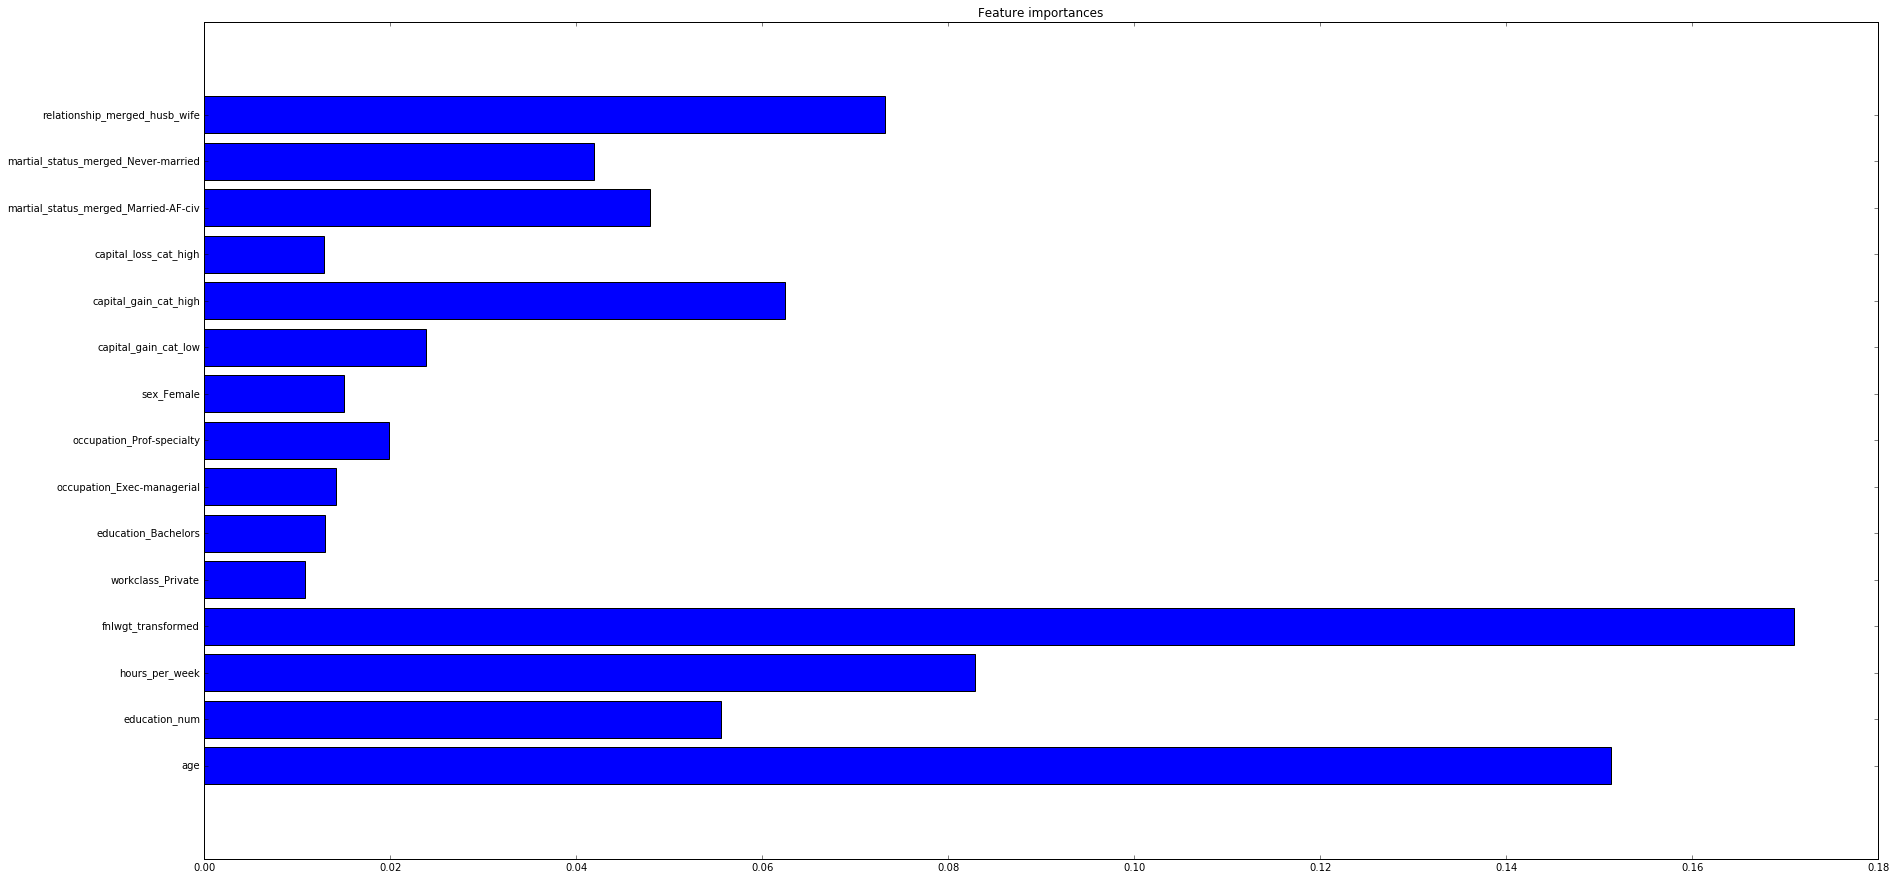

In [84]:
'''
Variable importance plot
'''
%pylab inline 
plt.figure(figsize=(30,15))

lists = importances[important_feature_index]
plt.title("Feature importances")
plt.barh(range(0,15), lists, color="b", align="center")
plt.yticks(range(0,15), names[0:15])
plt.show()

## Model Evaluation

* Logistic Regression

In [85]:
'''
Logistic Regression Model Evaluation using training data.
'''

print "\nSnapshot of the predictions from the Logistic Model:"
predictions_logistic = lr.predict(testing_data) #generate predictions
print predictions_logistic


print "\n\nThe Classifier predicts 1 any time the probability in the second column is greater than 0.5:"
probabilities = lr.predict_proba(testing_data) #generate class probabilities
print probabilities


print "\n\nEvaluation metrics: "
print "Accuracy of the model: %.2f" % (metrics.accuracy_score(test_y, predictions_logistic)*100),"%"
print "ROC accuracy score: %.2f"% (metrics.roc_auc_score(test_y, probabilities[:, 1])*100),"%"
print "Mean Squared error: %.2f" % (metrics.mean_squared_error(test_y,predictions_logistic)*100),'%'


print "\n\nConfusion Matrix: "
print metrics.confusion_matrix(test_y, predictions_logistic)


print "\n\nClassification Report: "
print metrics.classification_report(test_y, predictions_logistic)


Snapshot of the predictions from the Logistic Model:
[0 0 0 ..., 1 0 1]


The Classifier predicts 1 any time the probability in the second column is greater than 0.5:
[[ 0.99771095  0.00228905]
 [ 0.86553006  0.13446994]
 [ 0.58753263  0.41246737]
 ..., 
 [ 0.28798052  0.71201948]
 [ 0.95286962  0.04713038]
 [ 0.19552846  0.80447154]]


Evaluation metrics: 
Accuracy of the model: 64.94 %
ROC accuracy score: 49.48 %
Mean Squared error: 35.06 %


Confusion Matrix: 
[[9260 2263]
 [3106  686]]


Classification Report: 
             precision    recall  f1-score   support

          0       0.75      0.80      0.78     11523
          1       0.23      0.18      0.20      3792

avg / total       0.62      0.65      0.63     15315



* Support Vector Machines

In [86]:
'''
SVM Model Evaluation using training data.
'''

print "\nSnapshot of the predictions from the SVM Model:"
predictions_svm = svm.predict(testing_data) #generate predictions
print predictions_svm

print "\n\nEvaluation metrics:"
print "Accuracy of the model: %.2f" % (metrics.accuracy_score(test_y, predictions_svm)*100),"%"
print "Mean Squared error: %.2f" % (metrics.mean_squared_error(test_y,predictions_svm)*100),'%'


print "\n\nConfusion Matrix:"
print metrics.confusion_matrix(test_y, predictions_svm)

print "\n\nClassification Report:"
print metrics.classification_report(test_y, predictions_svm)


Snapshot of the predictions from the SVM Model:
[0 0 0 ..., 0 0 0]


Evaluation metrics:
Accuracy of the model: 71.96 %
Mean Squared error: 28.04 %


Confusion Matrix:
[[10823   700]
 [ 3594   198]]


Classification Report:
             precision    recall  f1-score   support

          0       0.75      0.94      0.83     11523
          1       0.22      0.05      0.08      3792

avg / total       0.62      0.72      0.65     15315



* Random Forest

In [87]:
'''
Random Forest Model Evaluation using training data.
'''

print "\nSnapshot of the predictions from the RF Model:"
predictions_rf = rf.predict(testing_data) #generate predictions
print predictions_rf


print "\n\nThe probabilities predicted by the Classifier:"
probabilities = rf.predict_proba(testing_data) #generate class probabilities
print probabilities


print "\n\nEvaluation metrics: "
print "Accuracy of the model: %.2f" % (metrics.accuracy_score(test_y, predictions_rf)*100),"%"
print "ROC accuracy score: %.2f"% (metrics.roc_auc_score(test_y, probabilities[:, 1])*100),"%"
print "Mean Squared error: %.2f" % (metrics.mean_squared_error(test_y,predictions_rf)*100),'%'


print "\n\nConfusion Matrix: "
print metrics.confusion_matrix(test_y, predictions_rf)


print "\n\nClassification Report: "
print metrics.classification_report(test_y, predictions_rf)


Snapshot of the predictions from the RF Model:
[0 0 0 ..., 1 0 1]


The probabilities predicted by the Classifier:
[[ 1.   0. ]
 [ 1.   0. ]
 [ 0.7  0.3]
 ..., 
 [ 0.2  0.8]
 [ 1.   0. ]
 [ 0.2  0.8]]


Evaluation metrics: 
Accuracy of the model: 64.86 %
ROC accuracy score: 49.44 %
Mean Squared error: 35.14 %


Confusion Matrix: 
[[9236 2287]
 [3094  698]]


Classification Report: 
             precision    recall  f1-score   support

          0       0.75      0.80      0.77     11523
          1       0.23      0.18      0.21      3792

avg / total       0.62      0.65      0.63     15315



* Gradient Boosting Machines

In [88]:
'''
GBM Model Evaluation using training data.
'''

print "\nSnapshot of the predictions from the RF Model:"
predictions_gb = gb.predict(testing_data) #generate predictions
print predictions_gb


print "\n\nThe probabilities predicted by the Classifier:"
probabilities = gb.predict_proba(testing_data) #generate class probabilities
print probabilities


print "\n\nEvaluation metrics: "
print "Accuracy of the model: %.2f" % (metrics.accuracy_score(test_y, predictions_gb)*100),"%"
print "ROC accuracy score: %.2f" % (metrics.roc_auc_score(test_y, probabilities[:, 1])*100),"%"
print "Mean Squared error: %.2f" % (metrics.mean_squared_error(test_y,predictions_gb)*100),'%'


print "\n\nConfusion Matrix: "
print metrics.confusion_matrix(test_y, predictions_gb)


print "\n\nClassification Report: "
print metrics.classification_report(test_y, predictions_gb)


Snapshot of the predictions from the RF Model:
[0 0 0 ..., 1 0 1]


The probabilities predicted by the Classifier:
[[ 0.98903998  0.01096002]
 [ 0.80234317  0.19765683]
 [ 0.64168005  0.35831995]
 ..., 
 [ 0.23628102  0.76371898]
 [ 0.90082379  0.09917621]
 [ 0.19792586  0.80207414]]


Evaluation metrics: 
Accuracy of the model: 64.88 %
ROC accuracy score: 49.52 %
Mean Squared error: 35.12 %


Confusion Matrix: 
[[9269 2254]
 [3124  668]]


Classification Report: 
             precision    recall  f1-score   support

          0       0.75      0.80      0.78     11523
          1       0.23      0.18      0.20      3792

avg / total       0.62      0.65      0.63     15315



## Parameter Tuning - SVM

In [89]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from operator import itemgetter
from time import time

In [90]:
'''
Utility function to report best scores
'''
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [ ]:
'''
Use a full grid over all parameters
'''
param_grid = {"C": [0.5, 1, 1.5], 
              "fit_intercept": [True, False],
              "multi_class": ['ovr','crammer_singer']}

# run grid search
grid_search = GridSearchCV(svm, param_grid=param_grid)
start = time()
grid_search.fit(training_data, train_y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)
print("\n")

In [ ]:
# include hyper-plot

The above hyper-parameters can be used to fit the model to the dataset to improve accuracy/fit

## Prediction Summary:

* Logistic Regression model:
    * Prediction Accuracy: **64.94%** 
    * F1-Score: **0.63**    
    
* Support Vector Machines model:
    * Prediction Accuracy: **71.96%** 
    * F1-Score: **0.65**   
    
* Random Forest model:
    * Prediction Accuracy: **64.86%** 
    * F1-Score: **0.63**    
    
* Gradient Boosting Machines model:
    * Prediction Accuracy: **64.88%** 
    * F1-Score: **0.63**